<a href="https://colab.research.google.com/github/LorraineMaira/Lorraine/blob/main/LABIA_P03_LorraineNeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numpy matplotlib pillow scikit-image

Iniciando FCM para LOGO CEFET.png com K=5, M=2, MAX_ITER=100
Convergiu na iteração 24. Mudança máxima: 0.000097


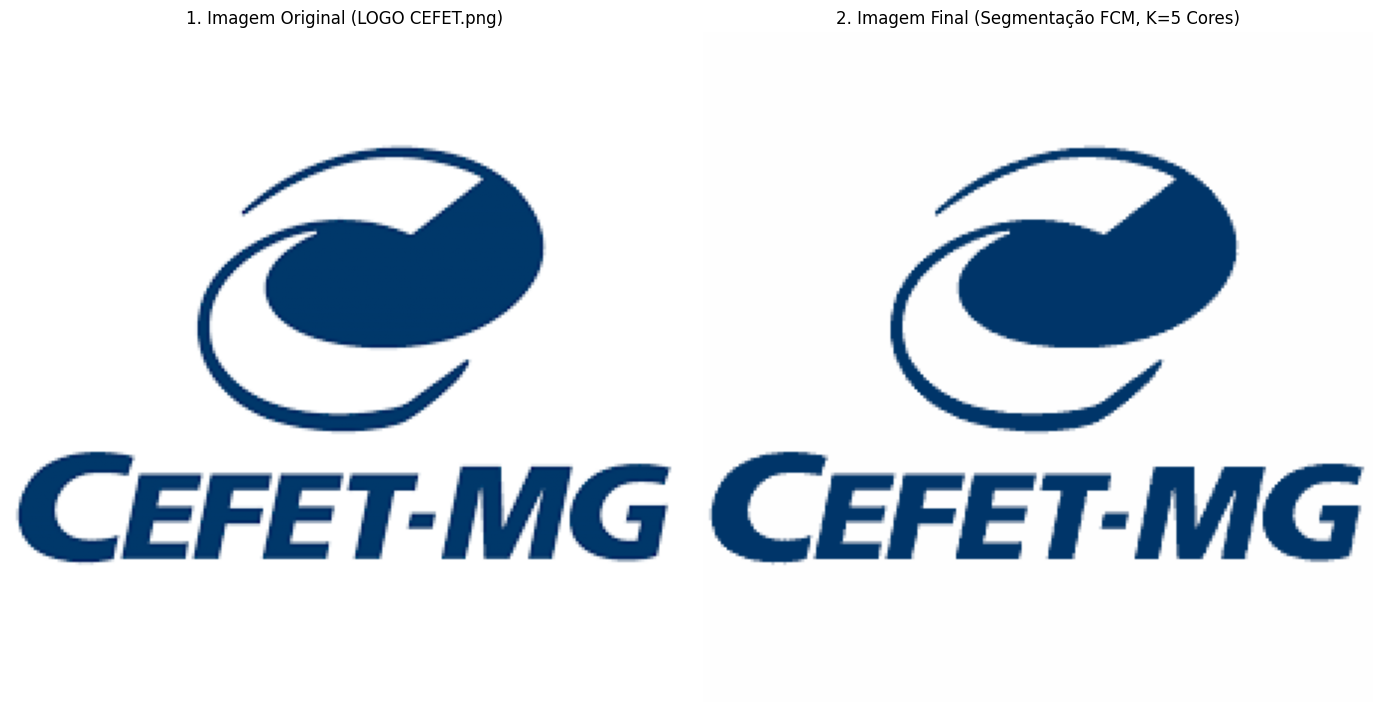

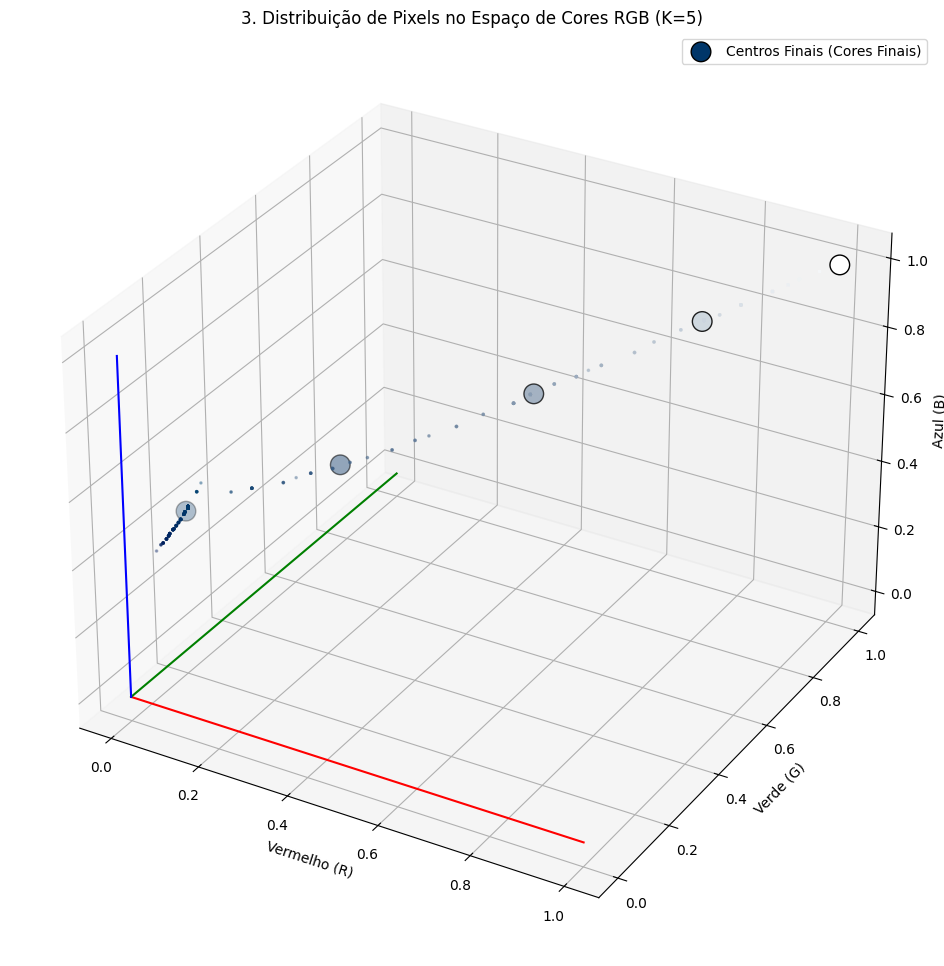

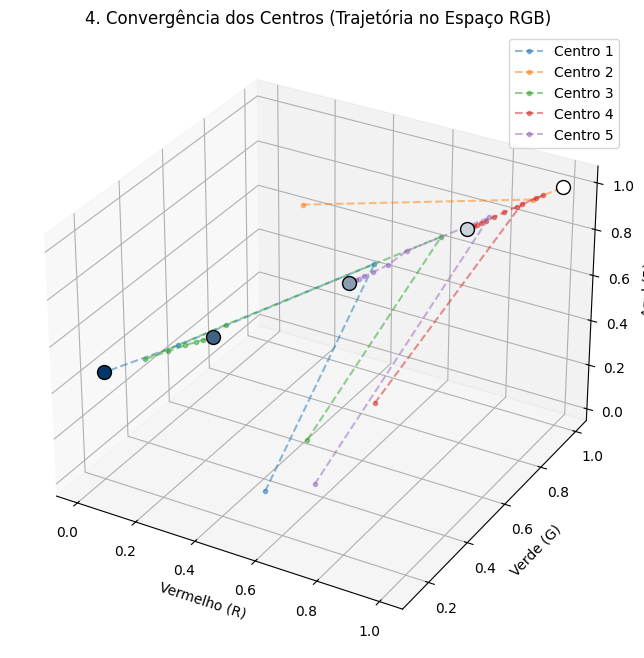

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings

# Suprimir avisos para uma saída mais limpa
warnings.filterwarnings("ignore")

# ==============================================================================
# 0. Parâmetros e Carregamento da Imagem
# ==============================================================================
# Caminho da imagem fornecido pelo usuário:
IMAGE_PATH = 'LOGO CEFET.png'
K = 5               # Número de clusters (cores finais), K=5 para um logotipo simples é um bom ponto de partida
M = 2               # Expoente fuzzy (m), tipicamente m=2
MAX_ITER = 100      # Número máximo de iterações
TOL = 1e-4          # Tolerância para convergência

def fcm_segmentation(image_path, k, m, max_iter, tol):
    """
    Realiza a segmentação de imagem e a redução de cores usando Fuzzy C-Means (FCM).
    """
    print(f"Iniciando FCM para {image_path} com K={k}, M={m}, MAX_ITER={max_iter}")

    # 1. Carregar e Pré-processar a Imagem
    try:
        # Abre a imagem e converte para RGB (garantindo 3 canais)
        img_pil = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"ERRO: Imagem não encontrada em '{image_path}'. Certifique-se de que o arquivo está na pasta correta.")
        return None, None, None, None, None, None

    img_original = np.array(img_pil) / 255.0  # Normalizar RGB para [0, 1]

    # Redimensionar a imagem para um array de pixels (N_pixels x 3 (R, G, B))
    N_ROWS, N_COLS, N_CHANNELS = img_original.shape
    X = img_original.reshape(-1, N_CHANNELS)
    N_PIXELS = X.shape[0]

    # 2. Inicialização do Algoritmo
    # Centros iniciais (cores aleatórias dentro do espaço [0, 1])
    C = np.random.rand(k, N_CHANNELS)
    U = np.zeros((N_PIXELS, k))  # Matriz de Pertinência (Membership)
    centers_history = [C.copy()] # Armazena centros para o gráfico de convergência

    # 3. Loop do Fuzzy C-Means (FCM)
    for a in range(max_iter):
        C_old = C.copy()

        # 3.1. Cálculo das Distâncias (D)
        # Distância Euclidiana (Norma L2) entre cada pixel e cada centro
        D = np.zeros((N_PIXELS, k))
        for j in range(k):
            D[:, j] = np.linalg.norm(X - C[j, :], axis=1)

        # Tratar a divisão por zero (pixel exatamente no centro)
        D[D == 0] = np.finfo(float).eps

        # 3.2. Atualização da Matriz de Pertinência (U)
        power = 2 / (m - 1)

        # Otimização do cálculo da soma no denominador:
        D_powered = D ** power

        # Sum_{l=1}^{k} (D_{ij} / D_{il})^{\frac{2}{m-1}} = (D_{ij})^{\frac{2}{m-1}} * Sum_{l=1}^{k} (1 / D_{il})^{\frac{2}{m-1}}
        # 1 / U[i, j] = Sum_{l=1}^{k} ( (D[i, j] / D[i, l])^power )

        # Implementação com loop para clareza (vetorizando a soma interna):
        U = np.zeros((N_PIXELS, k))
        for j in range(k):
            # Calcula a proporção de distâncias para o centro j em relação a todos os outros
            D_ratio = D[:, j, np.newaxis] / D
            denominator = np.sum(D_ratio ** power, axis=1)
            U[:, j] = 1.0 / denominator

        # 3.3. Atualização dos Centros (C)
        U_m = U ** m  # Pertinência elevada à potência 'm'

        for j in range(k):
            # C[j] = Sum(U_m * X) / Sum(U_m)
            numerator = np.dot(U_m[:, j], X)
            denominator = np.sum(U_m[:, j])
            C[j, :] = numerator / denominator

        # Armazenar centros e verificar convergência
        centers_history.append(C.copy())
        max_change = np.max(np.abs(C - C_old))

        if max_change < tol:
            print(f"Convergiu na iteração {a+1}. Mudança máxima: {max_change:.6f}")
            break

    else:
        print(f"Não convergiu em {max_iter} iterações. Mudança máxima: {max_change:.6f}")

    # 4. Reconstrução da Imagem
    # Atribuir o centro mais próximo (maior pertinência) a cada pixel.
    cluster_labels = np.argmax(U, axis=1)

    # Substituir a cor do pixel pela cor do centro
    img_reconstruida = C[cluster_labels].reshape(N_ROWS, N_COLS, N_CHANNELS)

    # Converter de volta para [0, 255] e tipo inteiro (uint8) para visualização
    img_final_uint8 = (img_reconstruida * 255).astype(np.uint8)

    return img_original, img_final_uint8, X, C, U, centers_history

# ==============================================================================
# 5. Execução e Visualização
# ==============================================================================

# Execute o algoritmo
img_original_norm, img_final_uint8, X_data, C_final, U_final, centers_hist = \
    fcm_segmentation(IMAGE_PATH, K, M, MAX_ITER, TOL)

if img_final_uint8 is None:
    exit()

# --- Gráfico 1: Imagem Original e Final ---
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Imagem Original (normalizada)
axes[0].imshow(img_original_norm)
axes[0].set_title('1. Imagem Original (LOGO CEFET.png)')
axes[0].axis('off')

# Imagem Segmentada/Redução de Cores (quantizada)
axes[1].imshow(img_final_uint8)
axes[1].set_title(f'2. Imagem Final (Segmentação FCM, K={K} Cores)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# --- Gráfico 2: Espaço de Cores RGB 3D ---
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

# Amostrar pixels para plotagem mais rápida (5000 pixels)
SAMPLE_SIZE = min(5000, X_data.shape[0])
sample_indices = np.random.choice(X_data.shape[0], SAMPLE_SIZE, replace=False)
X_sample = X_data[sample_indices]

# Plotar os pixels amostrados (cor de cada pixel)
ax.scatter(X_sample[:, 0], X_sample[:, 1], X_sample[:, 2],
           c=X_sample, marker='.', s=10, alpha=0.3)

# Plotar os Centros Finais (as K cores finais)
# O argumento 'c' no scatter aceita cores normalizadas [0, 1]
ax.scatter(C_final[:, 0], C_final[:, 1], C_final[:, 2],
           c=C_final, marker='o', s=200, edgecolors='k', label='Centros Finais (Cores Finais)')

ax.set_title(f'3. Distribuição de Pixels no Espaço de Cores RGB (K={K})')
ax.set_xlabel('Vermelho (R)')
ax.set_ylabel('Verde (G)')
ax.set_zlabel('Azul (B)')

# Adicionar um cubo de referência do espaço RGB
ax.plot([0, 1], [0, 0], [0, 0], 'r-')
ax.plot([0, 0], [0, 1], [0, 0], 'g-')
ax.plot([0, 0], [0, 0], [0, 1], 'b-')
ax.legend()
plt.show()

# --- Gráfico 3: Visualização da Convergência dos Clusters ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# Trajetória dos K centros no espaço RGB
for j in range(K):
    # Extrai a trajetória do centro j (R, G, B) ao longo das iterações
    center_traj = np.array([h[j, :] for h in centers_hist])

    # Plota a trajetória
    ax.plot(center_traj[:, 0], center_traj[:, 1], center_traj[:, 2],
            marker='.', linestyle='--', alpha=0.5, label=f'Centro {j+1}')

    # Plota a posição final com a cor final do cluster
    ax.scatter(center_traj[-1, 0], center_traj[-1, 1], center_traj[-1, 2],
               color=C_final[j, :], marker='o', s=100, edgecolors='k')

ax.set_title('4. Convergência dos Centros (Trajetória no Espaço RGB)')
ax.set_xlabel('Vermelho (R)')
ax.set_ylabel('Verde (G)')
ax.set_zlabel('Azul (B)')
plt.legend()
plt.show()